In [77]:
%matplotlib inline
import pandas as pd
import numpy as np
from skimage.io import imsave
from machinedesign.autoencoder.interface import load
from machinedesign.viz import grid_of_images_default, horiz_merge
from lightjob.cli import load_db
import keras.backend as K
import matplotlib.pyplot as plt
from IPython.display import Image
from fluentopt.utils import flatten_dict
import seaborn as sns
from scipy.stats import binned_statistic
pd.options.display.max_columns = 100
sns.set_style('white')
def show_several(df):
    for j in df.index:
        print(j)
        show_one(j)

def show_one(j):
    X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
    X = grid_of_images_default(X)
    imsave('out.png', X)
    im = Image('out.png')
    display(im)
    

In [116]:
db = load_db()
jobs = db.jobs_with()
rows = []
for j in jobs:
    col = {}
    if j['stats'] is None:
        continue
    for k, v in j['stats'].items():
        col[k] = v
        if type(v) is dict:
            for kk, v in v.items():
                col[kk]=v
                col[kk+'_'+k]=v
    try:
        col['stride'] = j['content']['train']['model']['params']['code_activations'][1]['params']['stride']
    except Exception:
        pass
    try:
        col['nb_layers'] = len(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        col['nb_layers'] = len(j['content']['train']['model'][1]['params']['encode_nb_filters'])    

    try:
         col['zero_ratio'] = j['content']['train']['model']['params']['code_activations'][1]['params']['zero_ratio']
    except Exception:
        pass
    try:
        col['bottleneck'] = min(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        pass
    try:
        col['noise'] = j['content']['train']['model'][0]['params']['params']['proba']
    except Exception:
        pass
    if 'digits_entropy' not in col:
        print(j['summary'])
    col['sampler'] = j['sampler']
    col['job_id'] = j['summary']
    col['noise_count'] = 1.0 - (col['digits_count'] + col['letters_count'])
    col['digits_object'] = 1 - col['digits_entropy']
    col['letters_object'] = 1 - col['letters_entropy']
    col['digits_and_letters_object'] = 1 - col['digits_and_letters_entropy']
    col['emnist_object'] = 1 - col['emnist_letters_entropy']
    rows.append(col)
    
df_full = pd.DataFrame(rows)
df_full = df_full.set_index('job_id')
df_full.to_csv('hypers.csv')

1bdc27c2d3ac13b35e4563f4d7295412


KeyError: 'digits_count'

In [49]:
df_full.head()

,bottleneck,digits,digits_and_letters_entropy,digits_and_letters_entropy_metrics,digits_and_letters_objectness,digits_and_letters_objectness_metrics,digits_count,digits_count_metrics,digits_diversity,digits_diversity_metrics,digits_entropy,digits_entropy_metrics,digits_frechet,digits_frechet_metrics,digits_max,digits_max_metrics,digits_mmd,digits_mmd_metrics,digits_objectness,digits_objectness_metrics,digits_recons_ratio,digits_test,digits_test_recons_ratio,emnist_digits_count,emnist_digits_count_metrics,emnist_digits_max,emnist_digits_max_metrics,emnist_letters_count,emnist_letters_count_metrics,emnist_letters_entropy,emnist_letters_entropy_metrics,emnist_letters_max,emnist_letters_max_metrics,emnist_objectness,emnist_objectness_metrics,hwrt_diversity,hwrt_diversity_metrics,hwrt_entropy,hwrt_entropy_metrics,hwrt_objectness,hwrt_objectness_metrics,hwrt_thin,hwrt_thin_recons_ratio,letters_count,letters_count_metrics,letters_diversity,letters_diversity_metrics,letters_entropy,letters_entropy_metrics,letters_frechet,letters_frechet_metrics,letters_max,letters_max_metrics,letters_mmd,letters_mmd_metrics,letters_objectness,letters_objectness_metrics,metrics,nb_layers,nb_params,nb_params_metrics,noise,ratio_unique,recons_ratio,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cd9b3b770c1b54d09b957e5f9398b7a6,128.0,0.0050,0.059236,0.059236,16.444881,16.444881,0.193,0.193,0.824364,0.824364,0.147444,0.147444,6.491843e+07,6.491843e+07,0.168,0.168,0.002002,0.002002,4.758044,4.758044,0.0050,0.0059,0.0059,0.029,0.029,0.027,0.027,0.761,0.761,0.276014,0.276014,0.202,0.202,6.600323,6.600323,0.548076,0.548076,0.064721,0.064721,17.664703,17.664703,0.0030,0.0030,0.735,0.735,0.849450,0.849450,0.184815,0.184815,1.426212e+08,1.426212e+08,0.589,0.589,0.002008,0.002008,9.245578,9.245578,"{'letters_frechet': 142621248.5703984, 'emnist...",1,6529.0,NaN,NaN,0.999,"{'digits_test': 0.0059, 'hwrt_thin': 0.003, 'd...",mnist_deep,1.0,NaN
c1eb1e14d01fdf37906ee5b1c9535bd8,128.0,1.0000,0.027041,0.027041,11.413067,11.413067,0.868,0.868,0.935180,0.935180,0.077866,0.077866,6.479927e+07,6.479927e+07,0.794,0.794,0.002000,0.002000,7.261310,7.261310,1.0000,0.9999,0.9999,0.088,0.088,0.086,0.086,0.532,0.532,0.253474,0.253474,0.167,0.167,10.828587,10.828587,0.705564,0.705564,0.106069,0.106069,38.176395,38.176395,0.7083,0.7083,0.098,0.098,0.799754,0.799754,0.086278,0.086278,1.426760e+08,1.426760e+08,0.090,0.090,0.002006,0.002006,10.333766,10.333766,"{'letters_frechet': 142676029.0936435, 'emnist...",5,3284353.0,NaN,NaN,1.000,"{'digits_test': 0.9999, 'hwrt_thin': 0.7083, '...",mnist_deep,1.0,NaN
a167259933f54183c717cd4ed0529081,128.0,0.9999,0.041000,0.041000,18.065023,18.065023,0.589,0.589,0.870865,0.870865,0.077320,0.077320,6.481716e+07,6.481716e+07,0.537,0.537,0.002000,0.002000,6.289638,6.289638,0.9999,1.0000,1.0000,0.098,0.098,0.089,0.089,0.579,0.579,0.234873,0.234873,0.188,0.188,13.520828,13.520828,0.794980,0.794980,0.108532,0.108532,60.633957,60.633957,0.9207,0.9207,0.330,0.330,0.926827,0.926827,0.109443,0.109443,1.425949e+08,1.425949e+08,0.279,0.279,0.002006,0.002006,14.407940,14.407940,"{'letters_frechet': 142594939.9838896, 'emnist...",2,825985.0,NaN,NaN,1.000,"{'digits_test': 1.0, 'hwrt_thin': 0.9207, 'dig...",mnist_deep,1.0,NaN
f316dedd30ebc5f51c4678f07979436c,128.0,1.0000,0.031410,0.031410,14.714568,14.714568,0.773,0.773,0.924139,0.924139,0.083757,0.083757,6.478472e+07,6.478472e+07,0.713,0.713,0.002000,0.002000,6.948976,6.948976,1.0000,1.0000,1.0000,0.081,0.081,0.073,0.073,0.572,0.572,0.254680,0.254680,0.178,0.178,12.290185,12.290185,0.775435,0.775435,0.104893,0.104893,55.180447,55.180447,0.9722,0.9722,0.172,0.172,0.926554,0.926554,0.101766,0.101766,1.426092e+08,1.426092e+08,0.153,0.153,0.002006,0.002006,14.877086,14.877086,"{'letters_frechet': 142609238.62671366, 'emnis...",3,1645441.0,NaN,NaN,1.000,"{'digits_test': 1.0, 'hwrt_thin': 0.9722, 'dig...",mnist_deep,1.0,NaN
ba180701c3c58a4de3f48662b850dc90,128.0,1.00

## Fix stride. vary nb of layers

In [50]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['stride']==2]
df = df.sort_values(by='nb_layers')
df

,bottleneck,digits,digits_and_letters_entropy,digits_and_letters_entropy_metrics,digits_and_letters_objectness,digits_and_letters_objectness_metrics,digits_count,digits_count_metrics,digits_diversity,digits_diversity_metrics,digits_entropy,digits_entropy_metrics,digits_frechet,digits_frechet_metrics,digits_max,digits_max_metrics,digits_mmd,digits_mmd_metrics,digits_objectness,digits_objectness_metrics,digits_recons_ratio,digits_test,digits_test_recons_ratio,emnist_digits_count,emnist_digits_count_metrics,emnist_digits_max,emnist_digits_max_metrics,emnist_letters_count,emnist_letters_count_metrics,emnist_letters_entropy,emnist_letters_entropy_metrics,emnist_letters_max,emnist_letters_max_metrics,emnist_objectness,emnist_objectness_metrics,hwrt_diversity,hwrt_diversity_metrics,hwrt_entropy,hwrt_entropy_metrics,hwrt_objectness,hwrt_objectness_metrics,hwrt_thin,hwrt_thin_recons_ratio,letters_count,letters_count_metrics,letters_diversity,letters_diversity_metrics,letters_entropy,letters_entropy_metrics,letters_frechet,letters_frechet_metrics,letters_max,letters_max_metrics,letters_mmd,letters_mmd_metrics,letters_objectness,letters_objectness_metrics,metrics,nb_layers,nb_params,nb_params_metrics,noise,ratio_unique,recons_ratio,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9e80faae4fb4ae36b2766648824eac09,128.0,0.0000,0.116791,0.116791,12.550046,12.550046,0.086,0.086,0.800376,0.800376,0.191304,0.191304,6.500855e+07,6.500855e+07,0.078,0.078,0.002076,0.002076,4.151053,4.151053,0.0000,0.0000,0.0000,0.018,0.018,0.013,0.013,0.757,0.757,0.352276,0.352276,0.141,0.141,5.123708,5.123708,0.522073,0.522073,0.082004,0.082004,14.290085,14.290085,0.0000,0.0000,0.848,0.848,0.810578,0.810578,0.347885,0.347885,1.427359e+08,1.427359e+08,0.501,0.501,0.002082,0.002082,5.316375,5.316375,"{'letters_frechet': 142735904.34361294, 'emnis...",1,6529.0,NaN,NaN,0.967,"{'digits_test': 0.0, 'hwrt_thin': 0.0, 'digits...",mnist_deep,2.0,NaN
68adffea6c98fedf329644122d56fa36,128.0,0.9848,0.039539,0.039539,19.538910,19.538910,0.577,0.577,0.911845,0.911845,0.087772,0.087772,6.482822e+07,6.482822e+07,0.517,0.517,0.002000,0.002000,6.700230,6.700230,0.9848,0.9847,0.9847,0.090,0.090,0.080,0.080,0.568,0.568,0.248701,0.248701,0.173,0.173,13.314023,13.314023,0.788424,0.788424,0.112240,0.112240,57.670715,57.670715,0.5403,0.5403,0.365,0.365,0.926126,0.926126,0.116562,0.116562,1.426116e+08,1.426116e+08,0.316,0.316,0.002006,0.002006,14.033784,14.033784,"{'letters_frechet': 142611569.8771668, 'emnist...",2,825985.0,NaN,NaN,1.000,"{'digits_test': 0.9847, 'hwrt_thin': 0.5403, '...",mnist_deep,2.0,NaN
901dad8ec11f23191d86fa6279d47c65,128.0,0.9964,0.031575,0.031575,15.541529,15.541529,0.707,0.707,0.915356,0.915356,0.084485,0.084485,6.481787e+07,6.481787e+07,0.656,0.656,0.002000,0.002000,6.845440,6.845440,0.9964,0.9959,0.9959,0.108,0.108,0.096,0.096,0.482,0.482,0.246643,0.246643,0.154,0.154,12.352144,12.352144,0.765771,0.765771,0.100727,0.100727,52.514980,52.514980,0.6943,0.6943,0.250,0.250,0.927061,0.927061,0.110468,0.110468,1.426481e+08,1.426481e+08,0.213,0.213,0.002006,0.002006,14.415942,14.415942,"{'letters_frechet': 142648051.56612384, 'emnis...",3,1645441.0,NaN,NaN,1.000,"{'digits_test': 0.9959, 'hwrt_thin': 0.6943, '...",mnist_deep,2.0,NaN
63c1be88f742117d115d076216ac85d1,128.0,0.9996,0.020904,0.020904,10.919588,10.919588,0.849,0.849,0.916866,0.916866,0.055326,0.055326,6.480193e+07,6.480193e+07,0.794,0.794,0.002000,0.002000,7.269512,7.269512,0.9996,0.9992,0.9992,0.130,0.130,0.121,0.121,0.440,0.440,0.208254,0.208254,0.196,0.196,10.687059,10.687059,0.676443,0.676443,0.095547,0.095547,33.215351,33.215351,0.6233,0.6233,0.124,0.124,0.778797,0.778797,0.088160,0.088160,1.426905e+08,1.426905e+08,0.113,0.113,0.002006,0.002006,9.548794,9.548794,"{'letters_frechet': 142690549.40551406, 'emnis...",4,2464897.0,NaN,NaN,1.000,"{'digits_test': 0.9992, 'hwrt_thin': 0.6233, '...",mnist_deep,2.0,NaN
581582abec259852f4a01f7e79ed97db,128.0,0.9837

In [ ]:
show(df)

## Fix nb layers. Vary stride

In [17]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['nb_layers'] == 3]
df = df.sort_values(by='stride')
df

,bottleneck,digits,digits_and_letters_entropy,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_objectness,digits_test,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_objectness,hwrt_diversity,hwrt_entropy,hwrt_objectness,hwrt_thin,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_objectness,metrics,nb_layers,nb_params,noise,ratio_unique,recons_ratio,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5511413bb44248b61f32518f638a8d9e,128.0,1.0000,0.043103,15.068205,0.712,0.912121,0.109552,6.482374e+07,0.621,0.002,6.414445,1.0000,0.031,0.029,0.694,0.310742,0.131,8.729666,0.646863,0.100108,26.331829,0.9966,0.231,0.917145,0.121261,1.426300e+08,0.193,0.002006,13.536750,"{'emnist_letters_count': 0.694, 'letters_frech...",3,1645441.0,NaN,1.0,"{'digits_test': 1.0, 'digits': 1.0, 'hwrt_thin...",mnist_deep,0.0,NaN
f316dedd30ebc5f51c4678f07979436c,128.0,1.0000,0.031410,14.714568,0.773,0.924139,0.083757,6.478472e+07,0.713,0.002,6.948976,1.0000,0.081,0.073,0.572,0.254680,0.178,12.290185,0.775435,0.104893,55.180447,0.9722,0.172,0.926554,0.101766,1.426092e+08,0.153,0.002006,14.877086,"{'emnist_letters_count': 0.572, 'letters_frech...",3,1645441.0,NaN,1.0,"{'digits_test': 1.0, 'digits': 1.0, 'hwrt_thin...",mnist_deep,1.0,NaN
901dad8ec11f23191d86fa6279d47c65,128.0,0.9964,0.031575,15.541529,0.707,0.915356,0.084485,6.481787e+07,0.656,0.002,6.845440,0.9959,0.108,0.096,0.482,0.246643,0.154,12.352144,0.765771,0.100727,52.514980,0.6943,0.250,0.927061,0.110468,1.426481e+08,0.213,0.002006,14.415942,"{'emnist_letters_count': 0.482, 'letters_frech...",3,1645441.0,NaN,1.0,"{'digits_test': 0.9959, 'digits': 0.9964, 'hwr...",mnist_deep,2.0,NaN
60168f92bfbc6331027b213e2e9d4f6f,128.0,0.9724,0.034976,13.157985,0.771,0.937145,0.083086,6.482572e+07,0.694,0.002,7.141914,0.9713,0.122,0.109,0.453,0.245890,0.142,10.135502,0.757821,0.114442,47.322350,0.3448,0.179,0.877613,0.115620,1.426912e+08,0.157,0.002006,12.196813,"{'emnist_letters_count': 0.453, 'letters_frech...",3,1645441.0,NaN,1.0,"{'digits_test': 0.9713, 'digits': 0.9724, 'hwr...",mnist_deep,4.0,NaN


# wta lifetime sparsity

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_lifetime']
df = df[df['zero_ratio']==0.7]
df = df.sort_values(by='nb_layers')
df

In [ ]:
show(df)

## wta kchannel

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['zero_ratio']==0.9]
df = df.sort_values(by='nb_layers')
df

In [ ]:
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['nb_layers']==4]
df = df.sort_values(by='zero_ratio')
df

In [ ]:
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_capacity']
df = df[df['nb_layers']==3]
df = df.sort_values(by='bottleneck', ascending=False)
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_noise']
df = df[df['nb_layers']==3]
df = df.sort_values(by='noise')
df = df[df['noise'] < 0.6]
show(df)

In [ ]:
df.plot('noise', ['digits_count'])

In [44]:
from IPython.display import Image
for j in df.index:
    print(j)
    X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
    X = grid_of_images_default(X)
    imsave('out.png', X)
    #im = Image('out.png')
    #display(im)

9e80faae4fb4ae36b2766648824eac09
68adffea6c98fedf329644122d56fa36
901dad8ec11f23191d86fa6279d47c65


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


63c1be88f742117d115d076216ac85d1
581582abec259852f4a01f7e79ed97db
8ecaf99d22cf4cb469912b9fae25aac2


In [42]:
x = df_full[['nb_layers', 'bottleneck', 'stride', 'zero_ratio', 'noise']].fillna(-1)
y = df_full['recons'].fillna(0.0)

KeyError: 'recons'

In [41]:
from scikitplot.estimators import plot_feature_importances
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg = GradientBoostingRegressor(n_estimators=30, max_depth=20)
reg.fit(x, y)
#reg.feature_importances_ = reg.coef_
plot_feature_importances(reg, feature_names=x.columns)

NameError: name 'x' is not defined

In [30]:
pd.DataFrame({'delta': np.abs(reg.predict(x)-y), 'y': y}).sample(10)

NameError: name 'reg' is not defined

In [ ]:
df_full.plot('emnist_letters_count', 'emnist_objectness', kind='scatter')

In [ ]:
d = df_full.copy()
#d['y'] = d['emnist_letters_count']
d['y'] =  d['emnist_letters_count'] + 5*d['emnist_object'] + 10*d['letters_diversity']
#d['y'] =  30*d['emnist_digits_count'] + d['emnist_objectness']
#d['y'] = d['letters_objectness']
d = d.sort_values(by='y', ascending=False)
show(d.iloc[0:10])

In [45]:
labels = [
    'digits_count', 
    'letters_count', 
    'digits_objectness', 
    'letters_objectness', 
    'digits_and_letters_objectness', 
    'emnist_objectness',
    'hwrt_thin_recons_ratio',
    'digits_test_recons_ratio',
    'ratio_unique'
]

d = df_full[labels].corr()
def m(val):
    color = 'yellow' if abs(val) > 0.8 else 'white'
    return 'background-color: %s' % color

d = d.style.applymap(m)
d

,digits_count,letters_count,digits_objectness,letters_objectness,digits_and_letters_objectness,emnist_objectness,hwrt_thin_recons_ratio,digits_test_recons_ratio,ratio_unique
digits_count,1,-0.905589,0.504355,0.383551,-0.0282334,0.47487,0.148895,0.43493,0.236343
letters_count,-0.905589,1,-0.421764,-0.295898,0.106046,-0.393857,-0.12278,-0.385441,-0.140513
digits_objectness,0.504355,-0.421764,1,0.911842,0.672366,0.954867,0.400622,0.668195,0.896522
letters_objectness,0.383551,-0.295898,0.911842,1,0.816927,0.942207,0.570089,0.691155,0.878726
digits_and_letters_objectness,-0.0282334,0.106046,0.672366,0.816927,1,0.697488,0.350752,0.369791,0.814643
emnist_objectness,0.47487,-0.393857,0.954867,0.942207,0.697488,1,0.464997,0.692201,0.860839
hwrt_thin_recons_ratio,0.148895,-0.12278,0.400622,0.570089,0.350752,0.464997,1,0.776738,0.404727
digits_test_recons_ratio,0.43493,-0.385441,0.668195,0.691155,0.369791,0.692201,0.776738,1,0.565984
ratio_unique,0.236343,-0.140513,0.896522,0.878726,0.814643,0.860839,0.404727,0.565984,1


In [102]:
d = df_full.copy()
d['y'] = 0.5 * d['letters_count'] + 0.5 * d['letters_diversity'] + d['letters_object']
d = d.sort_values(by='y', ascending=False)
d[['digits_count', 'letters_count',  'letters_diversity', 'digits_diversity', 'digits_objectness', 'letters_objectness', 'hwrt_objectness', 'sampler']].head()

KeyError: 'letters_object'

/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


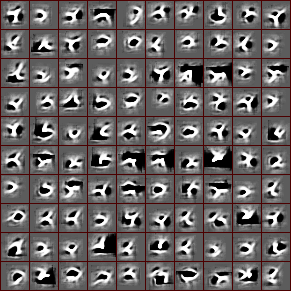

In [101]:
show_one('ed581618532492dcd910296a93ea2e5c')